## Imports

In [ ]:
import numpy as np
import pandas as pd
from sklearn import neighbors, metrics
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import cv2
import os
from zipfile import ZipFile

## Extract the datasets

In [ ]:
paths = ['/content/faces.zip', '/content/non_faces.zip']

for path in paths:
  with ZipFile(path, 'r') as zip:
    zip.extractall()

## Generating the Data Matrix & label vector

In [ ]:
# Generating Data Matrix D
D = []
for i in range(1,41):
  for j in range(1,11):
    a = cv2.imread('/content/s'+ str(i) + '/' + str(j) + '.pgm', 
                   cv2.IMREAD_GRAYSCALE).flatten()
    D.append(np.asarray(a, dtype=np.uint16))
dataset = pd.DataFrame(D)
# display(dataset)

# Generating label vector y
y = np.empty((0))
for i in range(1,41):
  x = np.arange(10)
  z = np.full_like(x, i)
  y = np.concatenate((y, z))
labels = pd.DataFrame(y, columns=['id'])
# display(labels)

## Split the Dataset into Training and Test sets

In [ ]:
training_features = dataset.iloc[lambda x: x.index % 2 == 1]
testing_features = dataset.iloc[lambda x: x.index % 2 == 0]

training_labels = labels.iloc[lambda x: x.index % 2 == 1]
testing_labels = labels.iloc[lambda x: x.index % 2 == 0] 

display(training_features)
display(testing_features)

display(training_labels)
display(testing_labels)

## Classification using PCA


### Compute covariance matrix, eigenvalues and eigenvectors

In [ ]:
def cov_eig(training):
  covariance = training.cov(ddof=0)

  # compute eigenvalues & compute eigenvectors -> projection matrix U (a)
  eigenvalues, eigenvectors = np.linalg.eigh(covariance)

  return covariance, eigenvalues, eigenvectors

In [ ]:
def PCA(training, testing, a, eigenvalues, eigenvectors):
  # Fraction of total variance
  sum_of_eigenvalues = np.sum(eigenvalues)
  sum = 0
  k = 0
  for j in range(10303, -1, -1): # for r from 1 to d
    k += 1 
    sum += eigenvalues[j]
    frac = sum / sum_of_eigenvalues
    if frac >= a:
      break

  # Get reduced basis
  Ur = eigenvectors[:, 10303] # eigenvector corrosponding to largest eigenvalue
  for x in range(10302, 10303-k, -1): # add column in each iteration
    Ur = np.hstack((Ur.reshape(10304,10303-x), 
                    eigenvectors[:, x].reshape(10304,1))) # add column to Ur

  # Projection
  projected_training_data = np.dot(training, Ur)
  projected_testing_data = np.dot(testing, Ur)
  return projected_training_data, projected_testing_data

### determine class labels using KNN


In [ ]:
def classification(training, testing, y_training, k):
  # determine class labels using KNN
  knn_classifier = neighbors.KNeighborsClassifier(n_neighbors=k)
  knn_classifier = knn_classifier.fit(training, 
                                      np.asarray(y_training).ravel())
  knn_predicted_class = knn_classifier.predict(testing)
  return knn_predicted_class

### Method to get accuracy

In [ ]:
def get_accuracy(actual, predicted):
  report = classification_report(actual , predicted, output_dict=True)
  return report.get('accuracy')

### accuracy of every value of alpha (d)


In [ ]:
def apply_PCA(training, testing, alpha, y_training, y_testing):
  covariance, eigenvalues, eigenvectors = cov_eig(training)
  projected_training_data, projected_testing_data = PCA(
      training, testing, alpha, eigenvalues, eigenvectors)
  predicted = classification(projected_training_data, 
                             projected_testing_data, y_training, 1)
  accuracy = get_accuracy(y_testing, predicted)
  return projected_training_data, projected_testing_data, predicted, accuracy

In [ ]:
def reporting_accuracy_PCA(training, testing, y_training, y_testing):
  alpha = [0.8, 0.85, 0.9, 0.95]
  covariance, eigenvalues, eigenvectors = cov_eig(training)
  acc = []
  for i in alpha:
    projected_training_data, projected_testing_data = PCA(
        training, testing, i, eigenvalues, eigenvectors)
    predicted_testing = classification(projected_training_data, 
                                       projected_testing_data, y_training, 1)
    accuracy = get_accuracy(y_testing, predicted_testing)
    print('alpha = ', i, '\t accuracy = ', accuracy)
    acc.append(accuracy)
  # plotting
  plt.scatter(np.transpose(alpha), np.transpose(acc), color='navy')
  plt.xlabel('alpha')
  plt.ylabel('accuracy')
  return alpha[np.argmax(acc)], predicted_testing

alpha =  0.8 	 accuracy =  0.93
alpha =  0.85 	 accuracy =  0.94
alpha =  0.9 	 accuracy =  0.945
alpha =  0.95 	 accuracy =  0.935


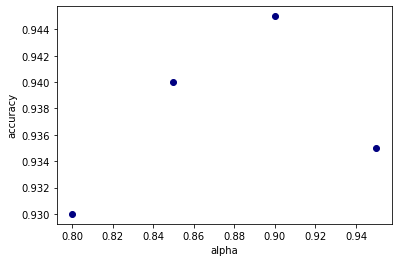

In [ ]:
max_alpha, _ = reporting_accuracy_PCA(training_features, testing_features, 
                                   training_labels, testing_labels)

Since alpha value and accuracy are not correlated, then we can say that there is no relation between them

## Classification Using LDA

#### Used methods in LDA

In [ ]:
def calculate_means(training):
  # class means
  mean_vectors = {}
  for i in range(0, 200, 5):
    mean_vectors[(i/5)+1] = (training.iloc[i:i+5 ,:].mean(axis='index')).to_numpy()
  
  # overall mean
  overall_mean = (training.mean(axis='index')).to_numpy()
  
  return mean_vectors, overall_mean

def calculate_Sb(mean_vectors, overall_mean):
  Sb = np.zeros((10304,10304))
  nk = 5
  for i in range(1, 41):
    Muk_Mu = np.subtract(mean_vectors[i], overall_mean)
    x = nk * np.dot(Muk_Mu.reshape((10304,1)), Muk_Mu.reshape((1,10304)))
    Sb = np.add(Sb, x)
  return Sb

def center_data(training, mean_vectors):
  Z = {}
  for i in range(0, 200, 5):
    Z[(i/5)+1] = training.iloc[i:i+5 ,:].subtract(mean_vectors[(i/5)+1] , axis=1)
  return Z

def calculate_S(Z):
  S = pd.DataFrame(np.zeros((10304, 10304)))
  for i in range(1, 41):
    S = S.add((Z[i].transpose()).dot(Z[i]))
  return S

In [ ]:
def LDA(training, testing, i):
  # calculate class means and overall mean
  mean_vectors, overall_mean = calculate_means(training)

  # between-class scatter matrix
  Sb = calculate_Sb(mean_vectors, overall_mean)

  # center class matrices
  Z = center_data(training, mean_vectors)

  # within_class scatter matrix
  S = calculate_S(Z)

  # compute dominant eigenvector
  eigenvalues, eigenvectors = np.linalg.eigh(np.dot(
      np.linalg.inv(S.to_numpy()), Sb))

  # get projection matrix
  # i = 10265, 10303
  U = np.flip(eigenvectors[:, i:10304], 1)

  # project training and testing 
  projected_training_data = np.dot(training, U)
  projected_testing_data = np.dot(testing, U)

  return projected_training_data, projected_testing_data

In [ ]:
def apply_LDA(training, testing, y_training, y_testing, i):
  projected_training_data, projected_testing_data = LDA(training, testing, i)
  predicted = classification(projected_training_data, 
                             projected_testing_data, y_training, 1)
  accuracy = get_accuracy(y_testing, predicted)
  print(accuracy)
  return projected_training_data, projected_testing_data, predicted, accuracy

In [ ]:
proj_train_LDA, proj_test_LDA, predicted_LDA, acc_LDA = apply_LDA(
    training_features, testing_features, training_labels, testing_labels, 10265)

0.945


In [ ]:
proj_train_PCA, proj_test_PCA, predicted_PCA, acc_PCA = apply_PCA(
    training_features, testing_features, max_alpha, training_labels, testing_labels)

## Classifier Tuning

In [ ]:
def tuning(projected_training_data, projected_testing_data, y_training, y_testing):
  K = [1, 3, 5, 7]
  a = []
  for i in K:
    predicted = classification(projected_training_data, 
                               projected_testing_data, y_training, i)
    accuracy = get_accuracy(y_testing, predicted)
    a.append(accuracy)
  
  print(a)
  # plotting
  plt.scatter(K, a, color='navy')
  plt.xlabel('K')
  plt.ylabel('accuracy')

PCA
[0.945, 0.85, 0.815, 0.755]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


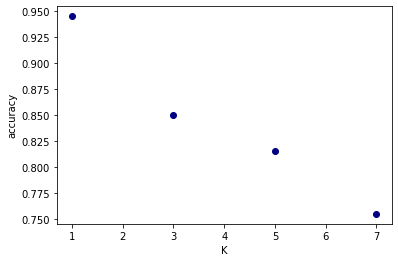

In [ ]:
print('PCA')
tuning(proj_train_PCA, proj_test_PCA, training_labels, testing_labels)

LDA
[0.945, 0.87, 0.84, 0.79]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

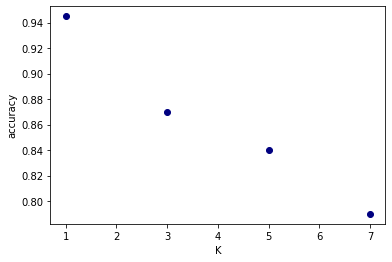

In [ ]:
print('LDA')
tuning(proj_train_LDA, proj_test_LDA, training_labels, testing_labels)

Accuracy of k=1 is better than k=2,3,4

## Compare vs Non-Face Images


### Read non-faces images

In [ ]:
# Change the directory
path = '/content/non_faces'
os.chdir(path)

# Iterate over all the files in the directory
non_faces = []
for file in os.listdir():
  file_path =f"{path}/{file}"
  # read image
  img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
  # resize image
  resized = cv2.resize(img, (92,112), interpolation = cv2.INTER_AREA)
  grayscaled = resized.flatten()
  non_faces.append(np.asarray(grayscaled, dtype=np.uint16))

non_faces_ds = pd.DataFrame(non_faces)
display(non_faces_ds)

# Generating label vector y_faces
y_faces = np.ones((400,1))
y_faces_ds = pd.DataFrame(y_faces, columns=['id'])

y_faces_training = y_faces_ds.sample(frac = 0.5)
y_faces_testing =  y_faces_ds.drop(y_faces_training.index)

,0,1,2,3,4,5,6,7,8,9,...,10294,10295,10296,10297,10298,10299,10300,10301,10302,10303
0,253,253,253,252,252,254,254,254,254,254,...,53,55,59,58,57,61,64,65,64,72
1,105,88,72,75,93,106,83,85,99,104,...,84,89,79,97,76,75,83,88,86,84
2,81,77,74,75,84,82,73,73,77,74,...,189,181,164,177,161,153,151,148,146,142
3,7,47,34,10,16,25,29,10,26,135,...,120,126,128,101,104,142,157,162,170,170
4,142,181,148,124,147,166,133,150,140,162,...,255,255,254,255,255,255,255,255,255,255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,65,65,65,65,67,67,67,68,68,69,...,144,144,144,145,146,147,147,145,143,144
596,169,166,169,162,156,159,156,157,164,167,...,113,112,128,100,50,76,66,96,94,133
597,206,206,203,203,204,204,205,202,201,199,...,117,123,132,131,145,150,140,121,121,126
598,85,92,95,86,65,49,50,46,44,44,...,72,73,75,74,76,76,77,77,77,77


In [ ]:
def faces_non_faces(n, train_percentage):  
  # Generating label vector y_non_faces
  y_non_faces = np.zeros((n,1))
  y_non_faces_ds = pd.DataFrame(y_non_faces, columns=['id'])

  non_faces = non_faces_ds.head(n)
  y_non_faces = y_non_faces_ds.head(n)

  non_faces_training = non_faces.sample(frac = train_percentage)
  non_faces_testing = non_faces.drop(non_faces_training.index)

  y_non_faces_training = y_non_faces_ds.sample(frac = train_percentage)
  y_non_faces_testing =  y_non_faces_ds.drop(y_non_faces_training.index)

  training_mixed = pd.concat([training_features, non_faces_training], 
                             axis=0, ignore_index=True)
  y_training_mixed = pd.concat([y_faces_training, y_non_faces_training], 
                               axis=0, ignore_index=True)

  testing_mixed = pd.concat([testing_features, non_faces_testing], 
                            axis=0, ignore_index=True)
  y_testing_mixed = pd.concat([y_faces_testing, y_non_faces_testing], 
                              axis=0, ignore_index=True)

  return training_mixed, testing_mixed, y_training_mixed, y_testing_mixed

In [ ]:
faces_non_faces_200_training_features, faces_non_faces_200_testing_features, faces_non_faces_200_training_labels, faces_non_faces_200_testing_labels = faces_non_faces(200, 0.5)
faces_non_faces_300_training_features, faces_non_faces_300_testing_features, faces_non_faces_300_training_labels, faces_non_faces_300_testing_labels = faces_non_faces(300, 0.5)
faces_non_faces_400_training_features, faces_non_faces_400_testing_features, faces_non_faces_400_training_labels, faces_non_faces_400_testing_labels = faces_non_faces(400, 0.5)
faces_non_faces_500_training_features, faces_non_faces_500_testing_features, faces_non_faces_500_training_labels, faces_non_faces_500_testing_labels = faces_non_faces(500, 0.5)
faces_non_faces_600_training_features, faces_non_faces_600_testing_features, faces_non_faces_600_training_labels, faces_non_faces_600_testing_labels = faces_non_faces(600, 0.5)

### PCA - Faces vs Non-faces

In [ ]:
def faces_vs_non_faces_PCA(training, testing, y_training, y_testing, alpha):
  proj_training, proj_testing, predicted, accuracy = apply_PCA(
      training, testing, alpha, y_training, y_testing)
  cm = metrics.confusion_matrix(y_testing, predicted)
  disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                                        display_labels=['0','1'])
  disp.plot()
  plt.show()
  testing_array = np.asarray(y_testing)
  print('Failure')
  for i in range(0, 300):
    if predicted[i] != testing_array[i]:
      img = np.reshape(np.asarray(testing.iloc[i]), (112, 92))
      plt.imshow(img, cmap='gray')
      plt.show()
      break
  print('Success')
  for i in range(0, 300):
    if predicted[i] == testing_array[i]:
      img = np.reshape(np.asarray(testing.iloc[i]), (112, 92))
      plt.imshow(img, cmap='gray')
      plt.show()
      break
  return accuracy

#### 200 samples of non-faces

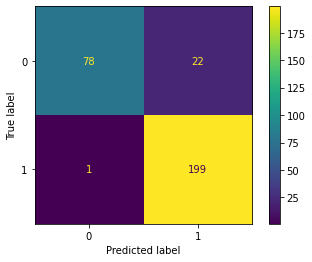

Failure


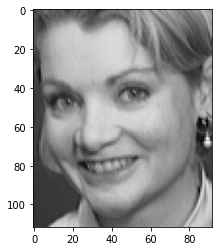

Success


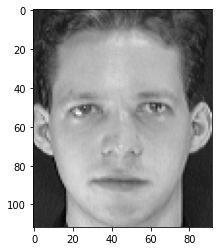

In [ ]:
acc_200 = faces_vs_non_faces_PCA(faces_non_faces_200_training_features, 
                                 faces_non_faces_200_testing_features, 
                                 faces_non_faces_200_training_labels, 
                                 faces_non_faces_200_testing_labels,
                                 0.9)

In [ ]:
print(acc_200)

0.9233333333333333


#### 300 samples of non-faces

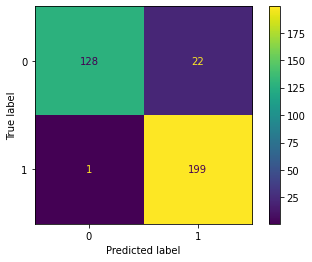

Failure


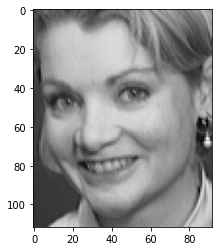

Success


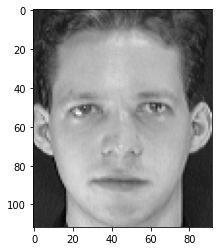

In [ ]:
acc_300 = faces_vs_non_faces_PCA(faces_non_faces_300_training_features, 
                                 faces_non_faces_300_testing_features, 
                                 faces_non_faces_300_training_labels, 
                                 faces_non_faces_300_testing_labels,
                                 0.9)

In [ ]:
print(acc_300)

0.9342857142857143


#### 400 samples of non-faces

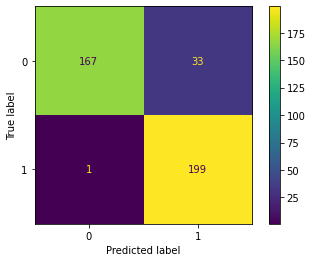

Failure


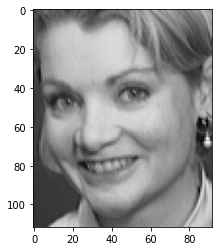

Success


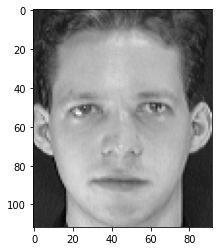

In [ ]:
acc_400 = faces_vs_non_faces_PCA(faces_non_faces_400_training_features, 
                                 faces_non_faces_400_testing_features, 
                                 faces_non_faces_400_training_labels, 
                                 faces_non_faces_400_testing_labels,
                                 0.9)

In [ ]:
print(acc_400)

0.915


#### 500 samples of non-faces

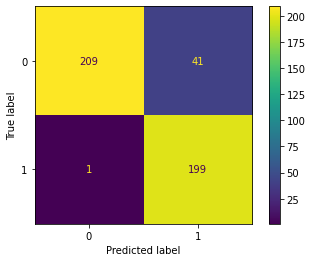

Failure


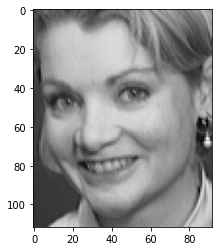

Success


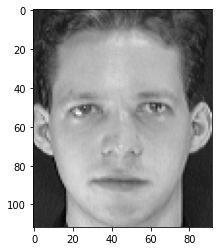

In [ ]:
acc_500 = faces_vs_non_faces_PCA(faces_non_faces_500_training_features, 
                                 faces_non_faces_500_testing_features, 
                                 faces_non_faces_500_training_labels, 
                                 faces_non_faces_500_testing_labels,
                                 0.9)

In [ ]:
print(acc_500)

0.9066666666666666


#### 600 samples of non-faces

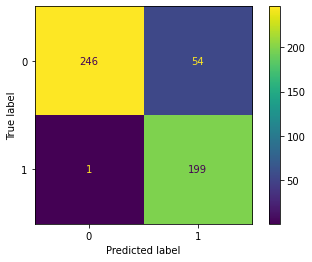

Failure


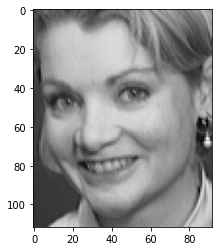

Success


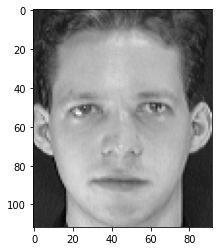

In [ ]:
acc_600 = faces_vs_non_faces_PCA(faces_non_faces_600_training_features, 
                                 faces_non_faces_600_testing_features, 
                                 faces_non_faces_600_training_labels, 
                                 faces_non_faces_600_testing_labels,
                                 0.9)

In [ ]:
print(acc_600)

#### Accuracy vs Number of samples

In [ ]:
acc_PCA = [acc_200, acc_300, acc_400, acc_500, acc_600]
samples = [200, 300, 400, 500, 600]
# plotting
plt.scatter(samples, acc_PCA, color='navy')
plt.xlabel('non-faces samples')
plt.ylabel('accuracy')

### LDA - Faces vs Non-faces

In [ ]:
def faces_vs_non_faces_LDA(training, testing, y_training, y_testing):
  proj_training, proj_testing, predicted, accuracy = apply_LDA(
      training, testing, y_training, y_testing, 10303)
  cm = metrics.confusion_matrix(y_testing, predicted)
  disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                                        display_labels=['0','1'])
  disp.plot()
  plt.show()
  testing_array = np.asarray(y_testing)
  print('Failure')
  for i in range(0, 300):
    if predicted[i] != testing_array[i]:
      img = np.reshape(np.asarray(testing.iloc[i]), (112, 92))
      plt.imshow(img, cmap='gray')
      plt.show()
      break
  print('Success')
  for i in range(0, 300):
    if predicted[i] == testing_array[i]:
      img = np.reshape(np.asarray(testing.iloc[i]), (112, 92))
      plt.imshow(img, cmap='gray')
      plt.show()
      break
  return accuracy

#### 200 samples of non-faces

0.6666666666666666


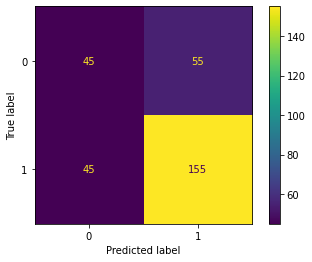

Failure


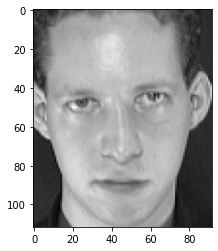

Success


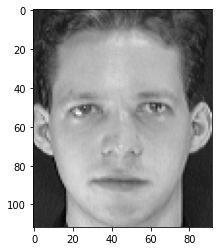

In [ ]:
acc_LDA_200 = faces_vs_non_faces_LDA(faces_non_faces_200_training_features, 
                                     faces_non_faces_200_testing_features, 
                                     faces_non_faces_200_training_labels, 
                                     faces_non_faces_200_testing_labels)

#### 300 samples of non-faces

In [ ]:
acc_LDA_300 = faces_vs_non_faces_LDA(faces_non_faces_300_training_features, 
                                     faces_non_faces_300_testing_features, 
                                     faces_non_faces_300_training_labels, 
                                     faces_non_faces_300_testing_labels)

#### 400 samples of non-faces

In [ ]:
acc_LDA_400 = faces_vs_non_faces_LDA(faces_non_faces_400_training_features, 
                                     faces_non_faces_400_testing_features, 
                                     faces_non_faces_400_training_labels, 
                                     faces_non_faces_400_testing_labels)

#### 500 samples of non-faces

0.7066666666666667


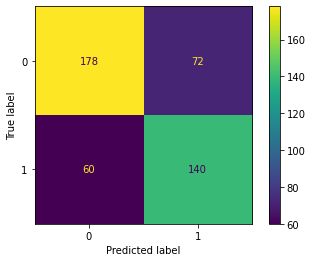

Failure


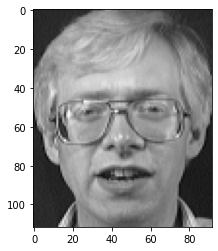

Success


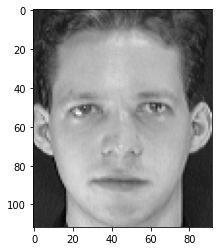

In [ ]:
acc_LDA_500 = faces_vs_non_faces_LDA(faces_non_faces_500_training_features, 
                                     faces_non_faces_500_testing_features, 
                                     faces_non_faces_500_training_labels, 
                                     faces_non_faces_500_testing_labels)

#### 600 samples of non-faces

0.73


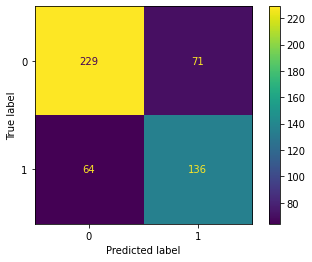

Failure


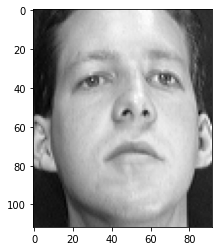

Success


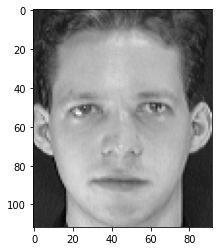

In [ ]:
acc_LDA_600 = faces_vs_non_faces_LDA(faces_non_faces_600_training_features, 
                                     faces_non_faces_600_testing_features, 
                                     faces_non_faces_600_training_labels, 
                                     faces_non_faces_600_testing_labels)

#### Accuracy vs Nuumber of images

Text(0, 0.5, 'accuracy')

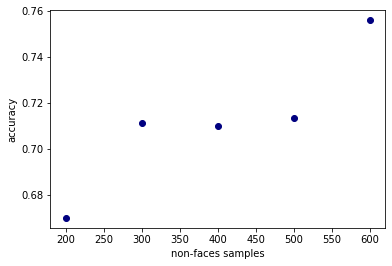

In [ ]:
acc_LDA = [0.67, 0.7114, 0.71, 0.7133, 0.756]
samples = [200, 300, 400, 500, 600]
# plotting
plt.scatter(samples, acc_LDA, color='navy')
plt.xlabel('non-faces samples')
plt.ylabel('accuracy')

## Bonus

In [ ]:
# Training
# Generating Data Matrix D
D_training = []
for i in range(1,41):
  for j in range(1,8):
    a_training = cv2.imread('/content/s'+ str(i) + '/' + str(j) + '.pgm', cv2.IMREAD_GRAYSCALE).flatten()
    D_training.append(np.asarray(a_training, dtype=np.uint16))
dataset_training = pd.DataFrame(D_training)
display(dataset_training)

# Generating label vector y
y_training = np.empty((0))
for i in range(1,41):
  x_training = np.arange(7)
  z_training = np.full_like(x_training, i)
  y_training = np.concatenate((y_training, z_training))
labels_training = pd.DataFrame(y_training, columns=['id'])
display(labels_training)


# Testing
# Generating Data Matrix D
D_testing = []
for i in range(1,41):
  for j in range(8,11):
    a_testing = cv2.imread('/content/s'+ str(i) + '/' + str(j) + '.pgm', cv2.IMREAD_GRAYSCALE).flatten()
    D_testing.append(np.asarray(a_testing, dtype=np.uint16))
dataset_testing = pd.DataFrame(D_testing)
display(dataset_testing)

# Generating label vector y
y_testing = np.empty((0))
for i in range(1,41):
  x_testing = np.arange(3)
  z_testing = np.full_like(x_testing, i)
  y_testing = np.concatenate((y_testing, z_testing))
labels_testing = pd.DataFrame(y_testing, columns=['id'])
display(labels_testing)

,0,1,2,3,4,5,6,7,8,9,...,10294,10295,10296,10297,10298,10299,10300,10301,10302,10303
0,48,49,45,47,49,57,39,42,53,49,...,39,44,40,41,49,42,44,47,46,46
1,60,60,62,53,48,51,61,60,71,68,...,27,35,28,33,31,31,37,32,34,34
2,39,44,53,37,61,48,61,45,35,40,...,23,30,36,32,28,32,31,29,26,29
3,63,53,35,36,33,34,31,35,39,43,...,173,169,166,161,158,169,137,41,10,24
4,64,76,80,53,34,72,60,66,66,50,...,31,28,34,32,35,34,35,35,37,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,131,125,126,131,125,129,125,127,127,127,...,91,89,90,90,93,88,93,89,93,91
276,130,123,127,125,126,126,127,125,125,127,...,39,34,33,37,34,38,41,33,37,40
277,128,125,125,129,128,132,125,133,125,131,...,87,86,87,92,88,85,91,85,90,84
278,123,121,126,122,127,127,123,124,123,127,...,29,47,34,36,42,34,39,40,35,42


,id
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
275,40.0
276,40.0
277,40.0
278,40.0


,0,1,2,3,4,5,6,7,8,9,...,10294,10295,10296,10297,10298,10299,10300,10301,10302,10303
0,44,43,32,32,30,30,38,40,48,66,...,37,42,42,40,33,29,37,43,43,37
1,42,41,44,46,48,39,37,37,33,37,...,42,33,39,39,40,41,43,42,43,41
2,34,34,33,32,38,40,39,49,54,57,...,42,44,38,30,37,30,36,37,40,33
3,34,39,35,38,34,41,37,36,35,39,...,139,143,144,134,139,142,128,135,138,148
4,43,39,36,40,36,40,38,39,37,36,...,124,114,101,72,54,82,141,154,155,141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,86,90,87,90,91,88,88,90,87,91,...,132,132,127,131,139,139,137,127,124,126
116,89,87,92,88,91,84,91,90,85,89,...,87,91,96,84,55,19,63,93,112,109
117,125,119,124,125,124,121,123,125,123,123,...,40,34,38,37,32,41,40,36,39,40
118,119,120,120,118,120,121,121,116,120,121,...,63,88,87,97,101,91,93,89,94,85


,id
0,1.0
1,1.0
2,1.0
3,2.0
4,2.0
...,...
115,39.0
116,39.0
117,40.0
118,40.0


alpha =  0.8 	 accuracy =  0.9583333333333334
alpha =  0.85 	 accuracy =  0.9666666666666667
alpha =  0.9 	 accuracy =  0.9666666666666667
alpha =  0.95 	 accuracy =  0.95
0.85


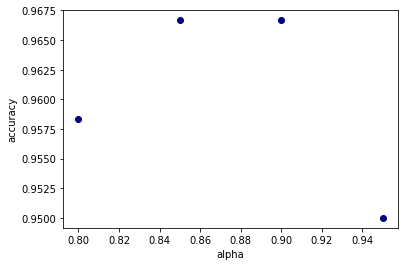

In [ ]:
max_alpha_bonus, predicted_bonus = reporting_accuracy_PCA(dataset_training, dataset_testing, labels_training, labels_testing)
print(max_alpha_bonus)

In [ ]:
def calculate_means_bonus(training):
  # class means
  mean_vectors = {}
  for i in range(0, 280, 7):
    mean_vectors[(i/7)+1] = (training.iloc[i:i+7 ,:].mean(axis='index')).to_numpy()
  
  # overall mean
  overall_mean = (training.mean(axis='index')).to_numpy()
  
  return mean_vectors, overall_mean

def calculate_Sb_bonus(mean_vectors, overall_mean):
  Sb = np.zeros((10304,10304))
  nk = 7
  for i in range(1, 41):
    Muk_Mu = np.subtract(mean_vectors[i], overall_mean)
    x = nk * np.dot(Muk_Mu.reshape((10304,1)), Muk_Mu.reshape((1,10304)))
    Sb = np.add(Sb, x)
  return Sb

def center_data_bonus(training, mean_vectors):
  Z = {}
  for i in range(0, 280, 7):
    Z[(i/7)+1] = training.iloc[i:i+7 ,:].subtract(mean_vectors[(i/7)+1] , axis=1)
  return Z

def LDA_bonus(training, testing):
  # calculate class means and overall mean
  mean_vectors, overall_mean = calculate_means_bonus(training)

  # between-class scatter matrix
  Sb = calculate_Sb_bonus(mean_vectors, overall_mean)

  # center class matrices
  Z = center_data_bonus(training, mean_vectors)

  # within_class scatter matrix
  S = calculate_S(Z)

  # compute dominant eigenvector
  eigenvalues, eigenvectors = np.linalg.eigh(np.dot(np.linalg.inv(S.to_numpy()), Sb))

  # get projection matrix
  U = np.flip(eigenvectors[:, 10265:10304], 1)

  # project training and testing 
  projected_training_data = np.dot(training, U)
  projected_testing_data = np.dot(testing, U)

  return projected_training_data, projected_testing_data

def apply_LDA_bonus(training, testing):
  projected_training_data, projected_testing_data = LDA_bonus(training, testing)
  predicted = classification(projected_training_data, projected_testing_data, labels_training, 1)
  accuracy = get_accuracy(labels_testing, predicted)
  print(accuracy)
  return projected_training_data, projected_testing_data, predicted, accuracy

In [ ]:
proj_train_LDA_bonus, proj_test_LDA_bonus, predicted_LDA_bonus, acc_LDA_bonus = apply_LDA_bonus(dataset_training, dataset_testing)

0.9416666666666667


PCA
[0.9666666666666667, 0.9333333333333333, 0.9083333333333333, 0.8416666666666667]


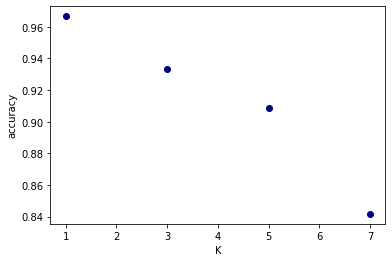

In [ ]:
proj_train_PCA_bonus, proj_test_PCA_bonus, predicted_PCA_bonus, acc_PCA_bonus = apply_PCA(dataset_training, dataset_testing, max_alpha_bonus, labels_training, labels_testing)

print('PCA')
tuning(proj_train_PCA_bonus, proj_test_PCA_bonus, labels_training, labels_testing)